### Import

In [28]:
import os
import csv

import json
import shutil
from io import StringIO
from pathlib import Path
from PIL import Image
from pdf2image import convert_from_path

import matplotlib.pyplot as plt

import cv2
from PIL import Image
import pytesseract

import fitz  # Módulo PyMuPDF
import re
from fuzzywuzzy import fuzz
from unidecode import unidecode
from unicodedata import normalize
import PyPDF2

import pandas as pd

from PIL import ImageFont
from PIL import Image, ImageDraw



import zipfile

from outlook_msg import Message
import extract_msg

import locale
from datetime import datetime, timezone, timedelta


from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar



### Config

In [2]:

# 1. path para documentos PDF (omelhor se estiverem dentro de um unico diretorio)
root_pdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao"

# 2. path para documentos PDF que podem estar aguardando para serem processados
root_pdf_aguardando_path = "pipeline_extracao_documentos/3_tratamento_excecoes/pdf_aguardando_processar"





# path para e-mails recebidos com documentos
email_recebido_documento_path = "pipeline_extracao_documentos/1_emails"





# 3. path para documentos PDF externos para serem processados
root_external_pdf_path = "content_from_pdftool/data/data_pdf/NF_para_processamento/NFRJ_PDF_para _ocr"
# 4. path para documentos PDF PESQUISAVEIS externos para serem processados
root_external_pdf_pesquisavel_path = "content_from_pdftool/data/data_pdf/NF_processadas/NFRJ/fwdnotasfiscaisemitidaslmpadalegal"




# 5. path para imagem padrao
image_resized_path = 'pipeline_extracao_documentos/6_geral_administacao/images/processadas'

# 6. path para log
log_path = 'pipeline_extracao_documentos/6_geral_administacao/logs'


# 7. path para arquivos json
json_path = "pipeline_extracao_documentos/5_documentos_processados/jsons"

# 8. path para NFs processadas
nf_processada_path = "pipeline_extracao_documentos/5_documentos_processados"



#### paths de objetos para criacao/gestao (dicionarios/datasets)

# 9. path para modelos
nf_model_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/frames_nf_v6.xlsx"

# 10. path para dicionario de modelos
model_dict_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/models.csv"

# 11. path para datasets CNAE e Itens de Serviço
nf_datasets_path = "pipeline_extracao_documentos/6_geral_administacao/datasets"



### PRESTAR ATENCAO
modelo = 'mage_1'


# VERIFICAR
tgt_imagens = "pipeline_extracao_documentos/6_geral_administacao/images"

# 12. poppler path
poppler_path = "/home/dani-boy/miniconda3/envs/tables-detr/bin"

# 13. path para config Tesseract
tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6'

In [40]:
#### IMPORTANTE - Nro Batch
batch_name = "Batch_1"

# 1. Caminho do arquivo uma mensagem especifica
msg_dir_path = 'pipeline_extracao_documentos/1_emails'

# 2. Path para arquivos atachados compactados
msg_attachment_zip = 'pipeline_extracao_documentos/1_emails/attachments'

# 3. Path para documentos atachados:
documentos_extracao_path = 'pipeline_extracao_documentos/2_documentos_para_extracao'



df_processamento = pd.read_csv('pipeline_extracao_documentos/6_geral_administacao/datasets/df_processamento.csv')

df_processamento.head()

,Unnamed: 0,Dt_hora,Assunto,Arquivos_zip,Pasta,Quantidade de Documentos,documentos,De,batch,email,Data,Hora
0,0,17/08/2023 16:11:50,Notas Magé,[],2953,[115],"['1124 fogo em 20-07-23 cancelada.pdf', '1127 ...",Bruna Maciel Adame,Batch_1,bruna@modernizacaopublica.com.br,17/08/2023,16:11:50


## Tratamento e-mail

In [ ]:
for root, dirs, files in os.walk(msg_dir_path):
    #print(f'{root}  | {dirs} | {document} | {files}\n')
    
    for file in files:
        file_path = os.path.join(root, file)

        if file.lower().endswith('.msg'):
            email_message = file
            email_path = os.path.join(root, file)
            print(f'email: {email_message}, email_path: {email_path}')
            
            
msg = extract_msg.Message(email_path)

msg_raw_sender = msg.sender

parts = msg_raw_sender.rsplit('<', 1)

msg_email_address = parts[1].strip('<>')

msg_sender = parts[0].strip(' ')

msg_subject = msg.subject


msg_body = msg.body

# Defina a localização para pt_BR
locale.setlocale(locale.LC_TIME, "pt_BR.utf8")


# String original
original_date_str = msg.date



    
    

In [ ]:
original_date_str

In [ ]:
# Utiliza expressão regular para extrair os componentes
match = re.search(r'(\d{2}) (\w{3}) (\d{4}) (\d{2}):(\d{2}):(\d{2}) ([+-]\d{4})', original_date_str)
if match:
    day, month_str, year, hour, minute, second, tz_offset = match.groups()
    
    month_map_en = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    month_map_pt = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

    # Detectar idioma do campo de data (um exemplo simples, você pode fazer algo mais robusto)
    if 'Jan' in original_date_str or 'Feb' in original_date_str or 'Mar' in original_date_str:
        month_map = month_map_en
    else:
        month_map = month_map_pt

# Continua com o resto do seu código

    month = month_map.get(month_str, 0)
    
    # Cria um objeto datetime
    dt = datetime(year=int(year), month=month, day=int(day),
                  hour=int(hour), minute=int(minute), second=int(second))
    
    # Ajusta o fuso horário
    offset_minutes = int(tz_offset) // 100 * 60 + int(tz_offset) % 100
    dt = dt.replace(tzinfo=timezone(timedelta(minutes=offset_minutes)))


    # Formata a data para o formato desejado (pt_BR)
    formatted_date_str = dt.strftime("%d/%m/%Y %H:%M:%S")
    #print(f"Data e horário formatados: {formatted_date_str}")

    # Formata apenas a data
    formatted_date = dt.strftime("%d/%m/%Y")
    #print(f"Data: {formatted_date}")

    # Formata apenas o horário
    formatted_time = dt.strftime("%H:%M:%S")
    #print(f"Horário: {formatted_time}")
    
    print(f'\nmsg_sender: {msg_sender}, msg_email_address: {msg_email_address}, msg_subject: {msg_subject} data: {formatted_date}, horario: {formatted_time} data completa: {formatted_date_str}')
else:
    print("Não foi possível fazer o parse da data.")

<h3 Salvando os attachments do e-mail </h3>

<h3> Tratando os anexos, zips </h3>

In [ ]:
import os
from outlook_msg import Message

# Caminho da pasta onde você quer salvar os anexos
pasta_destino = msg_attachment_zip

# Verifica se a pasta existe; se não, cria ela
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

with open(email_path) as msg_file:
    msg = Message(msg_file)

# Contents are the plaintext body of the email
#contents = msg.body


total_attch = len(msg.attachments)

print(total_attch)

arquivos_zip = []
i = 0
# Loop para salvar cada anexo
for i in range(total_attch):
    attachment = msg.attachments[i]
    caminho_completo_anexo = os.path.join(pasta_destino, attachment.filename)
    arquivos_zip.append(attachment.filename)
    print(caminho_completo_anexo)
    with attachment.open() as attachment_fp, open(caminho_completo_anexo, 'wb') as output_fp:
        output_fp.write(attachment_fp.read())



<mark> Extraindo documentos do ZIP </mark>

In [ ]:
# Diretório onde você quer salvar os arquivos extraídos
output_dir = os.path.join(documentos_extracao_path, batch_name)

folder_file_dict = {}

for root, dirs, files in os.walk(msg_attachment_zip):
    #print(f'{root}  | {dirs} | {document} | {files}\n')
    
    for file in files:
        file_path = os.path.join(root, file)

        if file.lower().endswith('.zip'):
            zip_file = file
            zip_file_path = os.path.join(root, file)
            print(zip_file_path)
            
            # Obtém o nome base do arquivo ZIP para usar como subdiretório
            zip_basename = os.path.splitext(os.path.basename(zip_file_path))[0]
            
            print(zip_basename)
            # Obtém o nome base do arquivo ZIP para usar como subdiretório
            zip_basename = os.path.splitext(os.path.basename(zip_file_path))[0]

            # Cria o subdiretório com base no nome do arquivo ZIP
            root_output_dir = os.path.join(output_dir, zip_basename)
            if not os.path.exists(root_output_dir):
                os.makedirs(root_output_dir) # estou criando o diretorio caso nao exista

            # Dicionário para guardar o nome da pasta e os arquivos associados
            

            # Abre o arquivo ZIP
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                for member in zip_ref.namelist():
                    # Separa o nome da pasta e o nome do arquivo usando barra invertida como delimitador
                    parts = member.rsplit('\\', 1)
                    folder_name = parts[0] if len(parts) > 1 else ''
                    filename = parts[-1]

                    if filename:  # ignora diretórios
                        # Adiciona ao dicionário
                        folder_file_dict.setdefault(folder_name, []).append(filename)

                        # Cria um subdiretório se ele não existir
                        sub_dir = os.path.join(root_output_dir, folder_name)
                        if not os.path.exists(sub_dir):
                            os.makedirs(sub_dir)

                        # Salva o arquivo no subdiretório especificado
                        source = zip_ref.open(member)
                        target_path = os.path.join(sub_dir, filename)
                        with open(target_path, "wb") as target:
                            target.write(source.read())


folder_file_dict

### 2. Dicionarios e Dataframe

In [ ]:
folder_names = []
file_counts = []
file_names = []

# Iterar sobre o dicionário para coletar informações
for folder, files in folder_file_dict.items():
    folder_names.append(folder)
    file_counts.append(len(files))
    file_names.append(files)


# Suponha que folder_file_dict é algo como {'pasta1': 'arquivo1.pdf', 'pasta2': 'arquivo2.pdf'}
folder_names = list(folder_file_dict.keys())
file_names = list(folder_file_dict.values())

In [ ]:
dfs = {} 
# Criar o DataFrame do batch
dfs[batch_name] = pd.DataFrame({
    "Dt_hora": [formatted_date_str],
    "Assunto": [msg_subject],
    "Arquivos_zip": [arquivos_zip],
    "Pasta": folder_names,
    "Quantidade de Documentos": [file_counts],
    "documentos": file_names,
    "De": [msg_sender],
    "batch": [batch_name],
    "email": [msg_email_address],
    "Data": [formatted_date],
    "Hora": [formatted_time],
})

df_batch = dfs[batch_name]

In [ ]:
df_processamento = dfs[batch_name]

In [ ]:
# Anexando o novo DataFrame ao original
df_processamento = df_processamento.append(df_batch, ignore_index=True)

df_processamento.head()

In [ ]:
# Anexando o novo DataFrame ao original
df_processamento = df_processamento.append(df_batch, ignore_index=True)

df_processamento.head()




In [ ]:
# Salvando o DF para csv
df_processamento.to_csv('pipeline_extracao_documentos/datasets/df_processamento.csv')

In [ ]:
# gerar excel a partir do df

df_main.to_excel("nome_do_arquivo.xlsx", index=False)


### Funcoes utilizadas

In [5]:
# 3. Cria o dict de modelos
# 2. Leitura do arquivo CSV e criação do dicionário modelos
def create_model_dictionary(model_dict_path):
    model_dictionary = {}
    with open(model_dict_path, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile)
        for row in csvreader:
            prefeitura_name = row['prefeitura']
            model_name = row['model']

            if prefeitura_name not in model_dictionary:
                model_dictionary[prefeitura_name] = model_name
            
            #model_dictionary[prefeitura_name].append(model_name)
    
    return model_dictionary



model_dict = create_model_dictionary(model_dict_path) 


## Consistencias dos documentos

In [ ]:
def convertResizeAnalise_1page(doc2convert, document_path, image_resized_path):
    
    """# 1. remocao do sufixo .pdf
    if doc2convert.split(".")[1].islower():
        nameImage= doc2convert.removesuffix(".pdf")
    else:
        nameImage= doc2convert.removesuffix(".PDF")"""
    
    # 2. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(doc2convert)}.jpg')
    
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    resized_pages = []
    for page in pages:
        resized_page = page.resize((2067, 2923))
        resized_pages.append(resized_page)
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name

In [ ]:
# 5. Verifica se PDF e pesquisavel ou nao e grava metadados dele
def is_pdf_searchable_analise(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        pages = pdf_document.page_count
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        dados_pdf = pdf_document.metadata
        pdf_document.close()
        return is_searchable, dados_pdf, pages
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

In [ ]:
# 2. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF_free(image_name, vx0, vy0, vx1, vy1):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = vx0
    y0 = vy0
    x1= vx1
    y1 = vy1

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 

In [ ]:
# 2. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF(image_name):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = 406
    y0 = 0
    x1= 1540
    y1 = 380

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 

In [ ]:
# 5. Interacao para pesquisar prefeitura
def pesquisa_texto(texto):
    nome_prefeitura_match = re.search(r'PREFEITURA (.+)', texto)
    if nome_prefeitura_match:
        is_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
        
        return  is_prefeitura
    else:
        raise ValueError("Nao consegui pesquisar")

In [ ]:
# Funcao importante - process_line

def process_line(value, reference, label):
    name_match = re.search(fr'{reference} (.+)', value)
    if name_match:
        extracted_value = reference + " " + name_match.group(1)
        return {label: extracted_value}
    return None

In [ ]:
# 1. dicionario para ocorrencias dos documentos pesquisados
analise_doc_nf = {}
file_data = []
# 2. caminho usado dinamicamente para funcao poder ser utizada em outras area da estrutura de diretorios
root_doc_analise = os.path.join(documentos_extracao_path, batch_name)
# Inicialização do DataFrame
colunas = ["documento", "pdf", "batch", "pesquisavel", "paginas", "metadata"]
analise_df = pd.DataFrame(columns=colunas)
i = 0
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    
    for file in files:
        file_path = os.path.join(root, file)
        dados_pdf = None  # Inicialização fora do try/catch
        
        if file.lower().endswith('.pdf'):
            documento_pdf = True

            pesquisavel, metadados, paginas = is_pdf_searchable_analise(file_path)
                
            if not pesquisavel:
                
                if paginas == 1:
                    #1. Converto para imagem
                    image_2work, name_image_2work = convertResizeAnalise_1page(file, file_path, image_resized_path)


                    #2_frame_dados_prestador:  0	552	2067	785


                    #2. Defino cordenandas, string_pesquisa e label  550	380	1357	555
                    v_x0 = 0#406
                    v_y0 = 552#0
                    v_x1 = 2067#1540
                    v_y1 = 785#380
                    string_pesquisa = "Nome/Razão Social:"
                    label = "testando pesquisas regex"
                    
                    #3. Print do teste
                    print(f'\nTeste nro: {i} | doc: {file} | pdf?: {documento_pdf} | pesquisavel?: {pesquisavel} | paginas: {paginas} | string_pesquisa: "{string_pesquisa}"\ncoordenadas ocr: v_x0 = {v_x0}, v_y0 = {v_y0}, v_x1 = {v_x1}, v_y1 = {v_y1}\n')
                    
                    #4. Processo OCR
                    text_splited, text_frame = ocr_RasterPDF_free(image_2work, v_x0, v_y0, v_x1, v_y1)
                                        
                    #5. Itero sobre text_splited (lista)
                    a = 0
                    for texto_spl in text_splited:
                        print(f'texto_spl linha {a}: {texto_spl}')
                        #6. chamo funcao process_line
                        verificacao_texto = process_line(texto_spl, string_pesquisa, label)
                        if verificacao_texto:
                            print(f'\n1. nro: {i} | file: {file}\nverificacao_texto: {verificacao_texto}\n')
                        a +=1    
                    
                   
                    #6. Imprimo valores de text_splited
                    print(f'2. text_splited:\n{text_splited}\n')
                    print(f'\n\n=============================================================================================')
                    
                    
                    i +=1
                    
                    
                
            

In [ ]:
# 1. dicionario para ocorrencias dos documentos pesquisados
analise_doc_nf = {}
file_data = []
# 2. caminho usado dinamicamente para funcao poder ser utizada em outras area da estrutura de diretorios
root_doc_analise = os.path.join(documentos_extracao_path, batch_name)


# Inicialização do DataFrame
colunas = ["documento", "pdf", "batch", "pesquisavel", "paginas", "metadata"]
analise_df = pd.DataFrame(columns=colunas)

for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    
    for file in files:
        file_path = os.path.join(root, file)
        dados_pdf = None  # Inicialização fora do try/catch
        
        if file.lower().endswith('.pdf'):
            documento_pdf = True
            try:
                pesquisavel, metadados, paginas = is_pdf_searchable_analise(file_path)
                
                
                                
                if not pesquisavel:
                    if paginas == 1:
                        image_2work, name_image_2work = convertResizeAnalise_1page(file, file_path, image_resized_path)
                        text_splited, text_frame  = ocr_RasterPDF(name_image_2work)
                    
                    
                    print(f'\ntext_splited: {text_splited}, text_frame: {text_frame}')
                    
                    #print(file, "nao e pesquisavel")
                
                
            except Exception as e:
                print(f"Erro ao verificar o PDF: {e}")
            # Adicionando uma nova linha ao DataFrame
            nova_linha_df = pd.DataFrame([{
                "pdf": documento_pdf,
                "documento": file,
                "batch": batch_name,
                "pesquisavel": pesquisavel,
                "paginas": paginas,
                "metadata": metadados
            }])
            
            analise_df['pdf'] = analise_df['pdf'].astype(bool)
            analise_df['pesquisavel'] = analise_df['pesquisavel'].astype(bool)

            analise_df = pd.concat([analise_df, nova_linha_df], ignore_index=True)

        else:
            documento_pdf = False
            # Adicione lógica para outros tipos de arquivo, se necessário

In [ ]:
analise_df

In [ ]:
# 1. Funcao de conversao e resize do documento
def convertResize_analise(nome_documento, document_path, image_resized_path):
    
    """# 1. remocao do sufixo .pdf
    if doc2convert.split(".")[1].islower():
        nameImage= doc2convert.removesuffix(".pdf")
    else:
        nameImage= doc2convert.removesuffix(".PDF")"""
    
    # 2. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(nome_documento)}.jpg')
    
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((2067, 2923))
            resized_pages.append(resized_page)
            
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name

In [ ]:
def pequisaModel(image_name):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = 406
    y0 = 0
    x1= 1540
    y1 = 380

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')

    # 5. Interacao para pesquisar prefeitura
    for value in values:
        nome_prefeitura_match = re.search(r'PREFEITURA (.+)', value)
        if nome_prefeitura_match:
            nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
            return  nome_prefeitura
        else:
            raise ValueError("Nao acho nome de prefeitura")

## Tratamento model

In [6]:
#Le a planilha e cria do DF
frames_nf_v3_df = pd.read_excel(nf_model_path)

In [7]:
frames_nf_v3_df

,model,seq,type,color,box,t_value,father,label,reference,x0,y0,x1,y1,Largura,Altura,%
0,mage_1,1,document,NaN,NaN,NaN,NaN,modelo_prefeitura_mage,NaN,0.0,0.0,2067.0,2923.0,2067.0,2923.0,NaN
1,mage_1,2,boundaries,green,yes,NaN,modelo_prefeitura_mage,boundaries_modelo_prefeitura_mage,NaN,144.0,99.0,1925.0,2666.0,1781.0,2567.0,100.000000
2,mage_1,3,section,red,yes,NaN,boundaries_modelo_prefeitura_mage,1_section_cabecalho_nf,NaN,0.0,0.0,2067.0,380.0,2067.0,380.0,14.803272
3,mage_1,4,frame,purple,yes,NaN,1_section_cabecalho_nf,1_frame_prefeitura_nf,NaN,406.0,0.0,1540.0,380.0,1030.0,380.0,NaN
4,mage_1,5,sframe_field,NaN,no,string,1_frame_prefeitura_nf,nome_prefeitura,PREFEITURA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,mage_1,73,field_box,orange,yes,string,5_frame_inf_criticas,issqn_retido,ISSQN RETIDO,1066.0,2425.0,1328.0,2521.0,262.0,96.0,NaN
73,mage_1,74,field_box,orange,yes,string,5_frame_inf_criticas,local_pretacao_servico,LOCAL. PRESTAÇÃO SERVIÇO,1328.0,2425.0,1638.0,2521.0,310.0,96.0,NaN
74,mage_1,75,field_box,orange,yes,string,5_frame_inf_criticas,local_incidencia,LOCAL INCIDÊNCIA,1638.0,2425.0,1922.0,2521.0,284.0,96.0,NaN
75,mage_1,76,frame,purple,NaN,NaN,6_section_inf_complementares_criticas,5_frame_observacao,uma observação,148.0,2521.0,1922.0,2676.0,1774.0,155.0,NaN


In [8]:
# Cria dicionários para armazenar diferentes tipos de elementos do modelo
document_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'document'].iloc[0]
boundaries_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'boundaries']
sections_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'section']
frames_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'frame']
sframe_fields_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'sframe_field']
field_boxes_info = frames_nf_v3_df[frames_nf_v3_df['type'] == 'field_box']

In [9]:
frames_info

,model,seq,type,color,box,t_value,father,label,reference,x0,y0,x1,y1,Largura,Altura,%
3,mage_1,4,frame,purple,yes,NaN,1_section_cabecalho_nf,1_frame_prefeitura_nf,NaN,406.0,0.0,1540.0,380.0,1030.0,380.0,NaN
7,mage_1,8,frame,purple,yes,NaN,1_section_cabecalho_nf,1_frame_dados_nf,NaN,1633.0,0.0,2067.0,380.0,434.0,380.0,NaN
13,mage_1,14,frame,purple,yes,NaN,2_section_prestador_servico,2_frame_cnpj_prestador,NaN,0.0,380.0,550.0,555.0,440.0,170.0,NaN
17,mage_1,18,frame,purple,yes,NaN,2_section_prestador_servico,2_frame_inscricao_prestador,NaN,550.0,380.0,1357.0,555.0,917.0,170.0,NaN
20,mage_1,21,frame,purple,yes,NaN,2_section_prestador_servico,2_frame_dados_prestador,NaN,0.0,552.0,2067.0,785.0,2067.0,235.0,NaN
26,mage_1,27,frame,purple,yes,NaN,3_section_tomador_servico,3_frame_cnpj_tomador,NaN,0.0,785.0,550.0,983.0,440.0,198.0,NaN
31,mage_1,32,frame,purple,yes,NaN,3_section_tomador_servico,3_frame_inscricao_tomador,NaN,550.0,785.0,1357.0,983.0,917.0,198.0,NaN
34,mage_1,35,frame,purple,yes,NaN,3_section_tomador_servico,3_frame_dados_tomador,NaN,0.0,983.0,2067.0,1154.0,2067.0,171.0,NaN
39,mage_1,40,frame,purple,yes,NaN,4_section_servicos_totais,4_frame_descricao_totais,NaN,0.0,1150.0,2067.0,1790.0,2067.0,690.0,NaN
41,mage_1,42,frame,purple,yes,NaN,4_section_servicos_totais,4_frame_valor_total,NaN,0.0,1743.0,2067.0,1852.0,2067.0,104.0,NaN


In [ ]:
sections_info

In [ ]:
sframe_fields_info

In [ ]:
field_boxes_info

### Funcoes

In [10]:
# 2. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF_free(image_name, vx0, vy0, vx1, vy1):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = vx0
    y0 = vy0
    x1= vx1
    y1 = vy1

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 


# 5. Verifica se PDF e pesquisavel ou nao e grava metadados dele
def is_pdf_searchable_analise(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        pages = pdf_document.page_count
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        dados_pdf = pdf_document.metadata
        pdf_document.close()
        return is_searchable, dados_pdf, pages
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

# 2. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF_free(image_name, vx0, vy0, vx1, vy1):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = vx0
    y0 = vy0
    x1= vx1
    y1 = vy1

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 

# Funcao importante - process_line

def process_line(value, reference, label):
    name_match = re.search(fr'{reference} (.+)', value)
    if name_match:
        extracted_value = reference + " " + name_match.group(1)
        return {label: extracted_value}
    return None


def convertResizeAnalise_1page(doc2convert, document_path, image_resized_path):
    
    """# 1. remocao do sufixo .pdf
    if doc2convert.split(".")[1].islower():
        nameImage= doc2convert.removesuffix(".pdf")
    else:
        nameImage= doc2convert.removesuffix(".PDF")"""
    
    # 2. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(doc2convert)}.jpg')
    
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    resized_pages = []
    for page in pages:
        resized_page = page.resize((2067, 2923))
        resized_pages.append(resized_page)
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name

# 2. Leitura do arquivo CSV e criação do dicionário modelos
def create_model_dictionary(model_dict_path):
    model_dictionary = {}
    with open(model_dict_path, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile)
        for row in csvreader:
            prefeitura_name = row['prefeitura']
            model_name = row['model']

            if prefeitura_name not in model_dictionary:
                model_dictionary[prefeitura_name] = model_name
            
            #model_dictionary[prefeitura_name].append(model_name)
    
    return model_dictionary





def extract_text_from_coordinates(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    frame_image = image.crop((x0, y0, x1, y1))
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=config).strip()
    return extracted_text


# secao: 8 - DADOS COMPLEMENTARES & 10. OBSERVACOES
def extract_dados_from_frame(modelo, frame_father, section):
    
    data_dados_frame = {}
    #frame_label = frame_father
    
    # 1. Filtrando o frames_info para buscar os dados de corte
    filtered_frames_info = frames_info[(frames_info['label'] == frame_father) & (frames_info['model'] == modelo)]

    # 2. Filtrando o sframe_fields_info para buscar os dados dos campos que estao nos frames
    filtered_sframe_fields_info = sframe_fields_info[(sframe_fields_info['father'] == frame_father) & (sframe_fields_info['model'] == modelo)]

    for index_frame, row_frame in filtered_frames_info.iterrows():
        
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        extracted_text_frame = extract_text_from_coordinates(image_2work, (x0, y0, x1, y1), tessdata_dir_config)
        
        
                
    return extracted_text_frame 

In [11]:
def format_number(number_str):
    # Check for percentage and handle it
    if '%' in number_str:
        number_str = number_str.replace('%', '')
        return float(number_str)  # You can multiply by 100 here if needed

    # Check if the string contains "R$" or a comma, indicating the original format
    if 'R$' in number_str or ',' in number_str:
        # Original format: Remove 'R$', replace dots with nothing, and replace commas with dots
        number_str = number_str.replace('R$', '').replace('.', '').replace(',', '.')
    else:
        # New format: Extract only the numeric part using regex
        number_str = re.findall(r'[\d\.]+', number_str)[-1]

    return float(number_str)

In [16]:
# Funçao de formatacao de numeros
def format_number2(number_str):
    number_str = number_str.replace('R$', '').replace('.', '').replace(',', '.')
    if '%' in number_str:
        number_str = number_str.replace('%', '')
        return float(number_str)  # multiplica por 100 para fields %
    return float(number_str)

In [12]:
def extract_text_from_frame(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    frame_image = image.crop((x0, y0, x1, y1))
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=config).strip()
    return extracted_text

In [17]:
def extract_fields_box(modelo, father_value, section):

    data_box_valores = {}
    data_box_valores['secao'] = section
    filtered_boxes_info = field_boxes_info[(field_boxes_info['father'] == father_value) & (field_boxes_info['model'] == modelo)]
    # Iterate nas informações dos boxes de fields e extraia o texto de cada field
    for index_field, row_field in filtered_boxes_info.iterrows():
        x0, y0, x1, y1 = row_field['x0'], row_field['y0'], row_field['x1'], row_field['y1']
        extracted_text_box = extract_text_from_frame(image_2work, (x0, y0, x1, y1), tessdata_dir_config)
        #print("{:<5} {:<10} {:<30} {:<20} {:<20} {:<7} {:<7} {:<7} {:<7}".format(row_field['seq'], row_field['model'], row_field['father'], row_field['label'], row_field['reference'], row_field['x0'], row_field['y0'], row_field['x1'], row_field['y1'] ))
        # Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
        value = extracted_text_box.split('\n')[-1]
        # Remova qualquer espaço em branco à esquerda ou à direita
        value = value.strip()
        if row_field['t_value'] == 'number':
            # Formate o valor usando a função format_number
            #print("vou verificar valor")
            value = format_number2(value)
            #print(value)
        # Armazene o texto extraído com o rótulo correspondente
        label = row_field['label']
        data_box_valores[label] = value
        
    return data_box_valores

# Modelo <mark>PDF Pesquisavel</mark> 

### Funcoes extracao PDF Pesquisavel

In [37]:
nf_data_servico = {}
# 0. Pesquisa PDF
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

# 1. CABECALHO
def extract_fields_cabecalho(text):
    nf_data_cabecalho = {}
    nf_data_cabecalho['secao'] = "1 - CABECALHO"
    
    
    # Extrair Nome da Prefeitura
    nome_prefeitura_match = re.search(r'PREFEITURA (.+)', text)
    if nome_prefeitura_match:
        nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
        nf_data_cabecalho['nome_prefeitura'] = nome_prefeitura

    # Extrair Tipo de NF
    tipo_nf_match = re.search(r'NOTA FISCAL (.+)', text)
    if tipo_nf_match:
        tipo_nf = "NOTA FISCAL " + tipo_nf_match.group(1)
        nf_data_cabecalho['tipo_nota_fiscal'] = tipo_nf
    
    # Extrair Número da Nota
    numero_nota_match = re.search(r'Número da Nota:\s+(\d+)', text)
    if numero_nota_match:
        nr_nro_nf = numero_nota_match.group(1)
        nf_data_cabecalho['numero_nota_fiscal'] = numero_nota_match.group(1)

    # Extrair Competência
    competencia_match = re.search(r'Competência:\s+(.+)', text)
    if competencia_match:
        nf_data_cabecalho['competencia'] = competencia_match.group(1)

    # Extrair Data e Hora de Emissão
    data_emissao_match = re.search(r'Data e Hora da Emissão:\s+(.+)', text)
    if data_emissao_match:
        nf_data_cabecalho['dt_hr_emissao'] = data_emissao_match.group(1)
        
    # Extrair Data e Hora de Emissão
    codigo_verificacao_match = re.search(r'Código Verificação:\s+(.+)', text)
    if codigo_verificacao_match:
        nf_data_cabecalho['codigo_verificacao'] = codigo_verificacao_match.group(1)    

    return nf_data_cabecalho

# 2. PRESTADOR DE SERVIÇO
def extract_fields_prestador(text): # Função para extrair campos e valores dentro de um retângulo
    nf_data_prestador = {}
    
    nf_data_prestador['secao'] = "2. PRESTADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_prestador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_prestador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_prestador['inscricao_municipal'] = inscricao_municipal_match.group(1)
        
               
    # Extrair Inscrição Estadual
    #if "Inscrição Estadual:" in text:
    
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_prestador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_prestador['inscricao_estadual'] = inscricao_estadual_match.group(1)       
        
                
    

    # Extrair Telefone
    #telefone_match = re.search(r'Telefone:\s+([0-9.\s-])', text)
    telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', text)
    if telefone_match: 
        telefone_str = telefone_match.group(1)
        # Remover quebras de linha
        telefone_str = telefone_str.replace('.', '')
        telefone_str = telefone_str.replace('\n', '')
                
        nf_data_prestador['telefone'] = telefone_str
    else:
        nf_data_prestador['telefone'] = "NONE"

         
                
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_prestador['razao_social'] = razao_social_match.group(1)  
                
    # Nome de Fantasia:
    nome_fantasia_match = re.search(r'Nome de Fantasia:\s+(.+)', text)
    if nome_fantasia_match:
        nf_data_prestador['nome_fantasia'] = nome_fantasia_match.group(1)                                    
                
            
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_prestador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_prestador['email'] = email_match.group(1)  
    else:
        nf_data_prestador['email'] = "NONE"  # Valor padrão quando não há correspondência
   
        

    return nf_data_prestador

# 3. TOMADOR DE SERVIÇO
def extract_fields_tomador(text):
    nf_data_tomador = {}
    
    
    nf_data_tomador['secao'] = "3. TOMADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_tomador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_tomador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

        
    # Extrair RG    
    rg_match = re.search(r'RG:\s+(.+)', text)   
    if rg_match:
        rg_str = rg_match.group(1)
        if rg_str == 'Telefone:':
            nf_data_tomador['rg'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['rg'] = rg_match.group(1)  
 
        
    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+(.+)', text)
    if telefone_match:
        telefone_str = telefone_match.group(1)
        if telefone_str == 'Inscrição Estadual:':
            nf_data_tomador['telefone'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['telefone'] = telefone_match.group(1)
     

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_tomador['inscricao_municipal'] = inscricao_municipal_match.group(1)
                
                
                
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_tomador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_tomador['inscricao_estadual'] = inscricao_estadual_match.group(1)   
                
    
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_tomador['razao_social'] = razao_social_match.group(1)                                                
                
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_tomador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_tomador['email'] = email_match.group(1) 
    else:
        nf_data_tomador['email'] = "NONE"  # Valor padrão quando não há correspondência    

    return nf_data_tomador

# 7. VALORES E IMPOSTOS
def extract_fields_impostos(text):
    nf_data_valores = {}
    nf_data_valores['secao'] = "7. VALORES E IMPOSTOS"
    
    # Extrair VALOR SERVIÇOS:
    valor_servicos_match = re.search(r'VALOR SERVIÇOS:\s+(.+)', text)
    if valor_servicos_match:
        valor_servicos_str = valor_servicos_match.group(1)
        valor_servicos_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_servicos_str)
        if valor_servicos_sem_formato:
            valor_servicos_sem_formatacao = valor_servicos_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_servicos'] = float(valor_servicos_sem_formatacao)
        else:
            nf_data_valores['valor_servicos'] = 0.0  # Valor não encontrado ou não está no formato esperado
  
  
    # Extrair VALOR DEDUÇÃO:
    valor_deducao_match = re.search(r'DEDUÇÃO:\s+(.+)', text)
    if valor_deducao_match:
        valor_deducao_str = valor_deducao_match.group(1)
        valor_deducao_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_deducao_str)
        if valor_deducao_sem_formato:
            valor_deducao_sem_formato = valor_deducao_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_deducao'] = float(valor_deducao_sem_formato)
        else:
            nf_data_valores['valor_deducao'] = 0.0  # Valor não encontrado ou não está no formato esperado
        
        
    # Extrair DESC. INCOND:
    valor_desc_match = re.search(r'DESC. INCOND:\s+(.+)', text)
    if valor_desc_match:
        valor_desc_str = valor_desc_match.group(1)
        valor_desc_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_str)
        if valor_desc_sem_formato:
            valor_desc_sem_formato = valor_desc_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_incond'] = float(valor_desc_sem_formato)
        else:
            nf_data_valores['desc_incond'] = 0.0  # Valor não encontrado ou não está no formato esperado        
        

    # Extrair BASE DE CÁLCULO:
    valor_calculo_match = re.search(r'CÁLCULO:\s+(.+)', text)
    if valor_calculo_match:
        valor_calculo_str = valor_calculo_match.group(1)
        valor_calculo_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_calculo_str)
        if valor_calculo_sem_formato:
            valor_calculo_sem_formato = valor_calculo_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['base_calculo'] = float(valor_calculo_sem_formato)
        else:
            nf_data_valores['base_calculo'] = 0.0  # Valor não encontrado ou não está no formato esperado    



    # Extrair ALÍQUOTA:
    valor_aliquota_match = re.search(r'ALÍQUOTA:\s+(.+)', text)
    if valor_aliquota_match:
        valor_aliquota_str = valor_aliquota_match.group(1)
        valor_aliquota_sem_formato = re.search(r'([\d.,]+)%', valor_aliquota_str)  # Ajuste aqui
        if valor_aliquota_sem_formato:
            valor_aliquota_sem_formato = valor_aliquota_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['aliquota'] = float(valor_aliquota_sem_formato)
        else:
            nf_data_valores['aliquota'] = 0.0  # Valor não encontrado ou não está no formato esperado


    # Extrair VALOR ISS:
    valor_iss_match = re.search(r'VALOR ISS:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_str = valor_iss_match.group(1)
        valor_iss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_str)
        if valor_iss_sem_formato:
            valor_iss_sem_formato = valor_iss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss'] = float(valor_iss_sem_formato)
        else:
            nf_data_valores['valor_iss'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR ISS RETIDO:
    valor_iss_retido_match = re.search(r'RETIDO:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_retido_str = valor_iss_retido_match.group(1)
        valor_iss_retido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_retido_str)
        if valor_iss_retido_sem_formato:
            valor_iss_retido_sem_formato = valor_iss_retido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss_retido'] = float(valor_iss_retido_sem_formato)
        else:
            nf_data_valores['valor_iss_retido'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR DESC. COND:
    valor_desc_cond_match = re.search(r'DESC. COND:\s+(.+)', text)
    if valor_desc_cond_match:
        valor_desc_cond_str = valor_desc_cond_match.group(1)
        valor_desc_cond_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_cond_str)
        if valor_desc_cond_sem_formato:
            valor_desc_cond_sem_formato = valor_desc_cond_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_cond'] = float(valor_desc_cond_sem_formato)
        else:
            nf_data_valores['desc_cond'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR PIS:
    valor_pis_match = re.search(r'VALOR PIS:\s+(.+)', text)
    if valor_pis_match:
        valor_pis_str = valor_pis_match.group(1)
        valor_pis_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_pis_str)
        if valor_pis_sem_formato:
            valor_pis_sem_formato = valor_pis_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_pis'] = float(valor_pis_sem_formato)
        else:
            nf_data_valores['valor_pis'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR COFINS:
    valor_cofins_match = re.search(r'VALOR COFINS:\s+(.+)', text)
    if valor_cofins_match:
        valor_cofins_str = valor_cofins_match.group(1)
        valor_cofins_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_cofins_str)
        if valor_cofins_sem_formato:
            valor_cofins_sem_formato = valor_cofins_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_cofins'] = float(valor_cofins_sem_formato)
        else:
            nf_data_valores['valor_cofins'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR IR:
    valor_ir_match = re.search(r'VALOR IR:\s+(.+)', text)
    if valor_ir_match:
        valor_ir_str = valor_ir_match.group(1)
        valor_ir_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_ir_str)
        if valor_ir_sem_formato:
            valor_ir_sem_formato = valor_ir_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_ir'] = float(valor_ir_sem_formato)
        else:
            nf_data_valores['valor_ir'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR INSS:
    valor_inss_match = re.search(r'VALOR INSS:\s+(.+)', text)
    if valor_inss_match:
        valor_inss_str = valor_inss_match.group(1)
        valor_inss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_inss_str)
        if valor_inss_sem_formato:
            valor_inss_sem_formato = valor_inss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_inss'] = float(valor_inss_sem_formato)
        else:
            nf_data_valores['valor_inss'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR CSLL:
    valor_csll_match = re.search(r'VALOR CSLL:\s+(.+)', text)
    if valor_csll_match:
        valor_csll_str = valor_csll_match.group(1)
        valor_csll_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_csll_str)
        if valor_csll_sem_formato:
            valor_csll_sem_formato = valor_csll_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_csll'] = float(valor_csll_sem_formato)
        else:
            nf_data_valores['valor_csll'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair OUTRAS RETENÇÕES:
    outras_retencoes_match = re.search(r'OUTRAS RETENÇÕES:\s+(.+)', text)
    if outras_retencoes_match:
        outras_retencoes_str = outras_retencoes_match.group(1)
        outras_retencoes_sem_formato = re.search(r'R\$\s*([\d.,]+)', outras_retencoes_str)
        if outras_retencoes_sem_formato:
            outras_retencoes_sem_formato = outras_retencoes_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['outras_retencoes'] = float(outras_retencoes_sem_formato)
        else:
            nf_data_valores['outras_retencoes'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    
    # Extrair VALOR LÍQUIDO:
    valor_liquido_match = re.search(r'VALOR LÍQUIDO:\s+(.+)', text)
    if valor_liquido_match:
        valor_liquido_str = valor_liquido_match.group(1)
        valor_liquido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_liquido_str)
        if valor_liquido_sem_formato:
            valor_liquido_sem_formato = valor_liquido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_liquido'] = float(valor_liquido_sem_formato)
        else:
            nf_data_valores['valor_liquido'] = 0.0  # Valor não encontrado ou não está no formato esperado
        

    return nf_data_valores


# 9. OUTRAS INFORMAÇOES / CRITICAS
def extract_fields_outras_info(text):
    nf_data_outras_informacoes = {}
    nf_data_outras_informacoes['secao'] = "9. OUTRAS INFORMAÇOES / CRITICAS"
    
    # Extrair EXIGIBILIDADE ISS:
    exigibilidade_iss_match = re.search(r'EXIGIBILIDADE ISS\s+(.+)', text)
    if exigibilidade_iss_match:
        exigibilidade_iss_value = exigibilidade_iss_match.group(1).strip()
        nf_data_outras_informacoes['exigibilidade_iss'] = exigibilidade_iss_value
        
    # Extrair REGIME TRIBUTAÇÃO:
    regime_tributacao_match = re.search(r'REGIME TRIBUTAÇÃO\s+(.+)', text)
    if regime_tributacao_match:
        regime_tributacao_value = regime_tributacao_match.group(1).strip()
        nf_data_outras_informacoes['regime_tributacao'] = regime_tributacao_value
    
    # Extrair SIMPLES NACIONAL:
    simples_nacional_match = re.search(r'SIMPLES NACIONAL\s+(.+)', text)
    if simples_nacional_match:
        simples_nacional_value = simples_nacional_match.group(1).strip()
        nf_data_outras_informacoes['simples_nacional'] = simples_nacional_value
        
        
    # Extrair ISSQN RETIDO:
    local_prestacao_servico_match = re.search(r'ISSQN RETIDO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['issqn_retido'] = local_prestacao_servico_value        
        
    
    # Extrair LOCAL PRESTAÇÃO SERVIÇO:
    local_prestacao_servico_match = re.search(r'LOCAL\. PRESTAÇÃO\s+SERVIÇO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['local_prestacao_servico'] = local_prestacao_servico_value
    
    
    
    # Extrair LOCAL INCIDÊNCIA:
    local_incidencia_match = re.search(r'LOCAL INCIDÊNCIA\s+(.+)', text)
    if local_incidencia_match:
        local_incidencia_value = local_incidencia_match.group(1).strip()
        nf_data_outras_informacoes['local_incidencia'] = local_incidencia_value
   
    
    return nf_data_outras_informacoes




In [34]:
numero_nota = nf_data_cabecalho['numero_nota_fiscal']

# Pipeline

In [39]:
# 1. dicionario para ocorrencias dos documentos pesquisados
nf_data_servico = {}

pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

analise_doc_nf = {}
file_data = []
# 2. caminho usado dinamicamente para funcao poder ser utizada em outras area da estrutura de diretorios
root_doc_analise = os.path.join(documentos_extracao_path, batch_name)
# Inicialização do DataFrame
colunas = ["documento", "pdf", "batch", "pesquisavel", "paginas", "metadata"]
analise_df = pd.DataFrame(columns=colunas)
i = 1
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    
    for file in files:
        file_path = os.path.join(root, file)
        dados_pdf = None  # Inicialização fora do try/catch
        
        if file.lower().endswith('.pdf'):
            documento_pdf = True

            pesquisavel, metadados, paginas = is_pdf_searchable_analise(file_path)
                
            if not pesquisavel:
                
                
                #if paginas == 1:
                if paginas > 1000:
                    model = "mage_1"
                    #1. Converto para imagem
                    
                    print(f'\nTeste nro: {i} | doc: {file} | pdf?: {documento_pdf} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n')
                    image_2work, name_image_2work = convertResizeAnalise_1page(file, file_path, image_resized_path)
                    
                    
                   
                    #frame_pesquisa = "1_frame_dados_nf"
                    #frame_pesquisa = "2_frame_dados_prestador"
                    #frame_pesquisa = "2_frame_inscricao_prestador"
                    #frame_pesquisa = "3_frame_inscricao_tomador"
                    #frame_pesquisa = "3_frame_dados_tomador"
                    #frame_pesquisa = "4_frame_descricao_totais"
                    #frame_pesquisa = "4_frame_valor_total"
                    #frame_pesquisa = "4_frame_cnae_itens_servico"
                    frame_pesquisa = "5_frame_valores_impostos"
                    
                    
                    if frame_pesquisa == "1_frame_prefeitura_nf":
                        # secao: 1 - CABECALHO
                        data_cabecalho = {}
                        f_father = "1_frame_prefeitura_nf"
                        section = "1 - CABECALHO"

                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido)
                        
                    elif frame_pesquisa == "1_frame_dados_nf":
                        # secao: 1 - CABECALHO
                        data_prestador = {}
                        f_father = "1_frame_dados_nf"
                        section = "1 - CABECALHO"

                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido)
                        
                    elif frame_pesquisa == "2_frame_cnpj_prestador":
                        # secao: 2. PRESTADOR DE SERVIÇO
                        data_prestador = {}
                        f_father = "2_frame_cnpj_prestador"
                        section = "2. PRESTADOR DE SERVIÇO"

                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido)
                        
                    elif frame_pesquisa == "2_frame_inscricao_prestador":
                        # secao: 2. PRESTADOR DE SERVIÇO
                        data_prestador = {}
                        f_father = "2_frame_inscricao_prestador"
                        section = "2. PRESTADOR DE SERVIÇO"

                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido)       
                        
                    elif frame_pesquisa == "2_frame_dados_prestador":
                        # secao: 2. PRESTADOR DE SERVIÇO
                        data_prestador = {}
                        f_father = "2_frame_dados_prestador"
                        section = "2. PRESTADOR DE SERVIÇO"

                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido)   
                        
                    elif frame_pesquisa == "3_frame_inscricao_tomador":
                        # secao: 3. TOMADOR DE SERVIÇO
                        data_tomador = {}
                        f_father = "3_frame_inscricao_tomador"
                        section = "3. TOMADOR DE SERVIÇO"
                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        print(Texto_extraido) 
                        
                    elif frame_pesquisa == "3_frame_dados_tomador":
                        # secao: 3. TOMADOR DE SERVIÇO
                        data_tomador = {}
                        f_father = "3_frame_dados_tomador"
                        section = "3. TOMADOR DE SERVIÇO"    
                        Texto_extraido = extract_fields_box_geral(model, f_father, section)
                        print(Texto_extraido)
                        
              
                    elif frame_pesquisa == "4_frame_descricao_totais":
                        # secao: 4 - DESCRIMINACAO DOS SERVIÇOS
                        data_servico = {}
                        result = {}
                        f_father = "4_frame_descricao_totais"
                        section = "4. DESCRIMINACAO DOS SERVIÇOS" 

                        vx_0 = 125
                        vy_0 = 1123
                        vx_1 = 1934
                        vy_1 = 1720

                        data_servico['secao'] = section
                        result, texto_extraido = ocr_RasterPDF_free(image_2work, vx_0, vy_0, vx_1, vy_1)
                        nf_data_servico = {}
                        label = "DISCRIMINAÇÃO DOS SERVIÇOS"
                        
                        if texto_extraido.startswith(label):
                            text = texto_extraido[len(label):].strip()
                        data_servico['discriminacao_servicos'] = text 
                        print(data_servico)
                        
                        
                       
                    elif frame_pesquisa == "4_frame_valor_total":
                        # secao: 5. VALOR TOTAL
                        data_CNAE = {}
                        f_father = "4_frame_valor_total"
                        section = "5. VALOR TOTAL"    
                        Texto_extraido = extract_fields_box_geral(model, f_father, section)
                        print(Texto_extraido) 
                        
                        
                         
                    elif frame_pesquisa == "4_frame_cnae_itens_servico":
                        # secao: 6. CNAE e Item da Lista de Serviços
                        data_CNAE = {}
                        f_father = "4_frame_cnae_itens_servico"
                        section = "6. CNAE e Item da Lista de Serviços"    
                        Texto_extraido = extract_fields_box(model, f_father, section)
                        
                        
                        
                    elif frame_pesquisa == "5_frame_valores_impostos":
                        data_valores = {}
                        result = {}
                        father_value = "5_frame_valores_impostos"
                        section = "7. VALORES E IMPOSTOS"

                        result = extract_fields_box(modelo, father_value, section)
                        if result:
                            data_valores.update(result)
                         

                        
                    elif frame_pesquisa == "5_frame_observacao":
                        # secao: 10. OBSERVACOES
                        data_observacao = {}
                        f_father = "5_frame_observacao"
                        section = "10. OBSERVACOES"
                        
                        Texto_extraido = extract_dados_from_frame(model, f_father, section)
                        Texto_extraido
                        
                    if i == 1:
                        break
                    
                print(f'\nRASTER PDF nro: {i} | doc: {file} | pdf?: {documento_pdf} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n')                    
                    

                
                    
                i +=1 
                
            else:
                #print(f'\nPDF PESQUISAVEL nro: {i} | doc: {file} | pdf?: {documento_pdf} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n')
                status = "O PDF é pesquisável"
                # Carregar o arquivo PDF
                pdf_document = fitz.open(file_path)
                # Página do PDF
                page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]

                # Definir retângulo de interesse
                x0 = 0
                y0 = 4
                x1 = 600
                y1 = 200  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                if text:
                    page_number = 0
                else:
                    page_number = 1
                
                
                # 1 - cabecalho
                #pdf_document = fitz.open(file_path)
                #page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]
                x0 = 0
                y0 = 0
                x1 = 600
                y1 = 110
                
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_cabecalho = extract_fields_cabecalho(text)
                
                
                try:
                    nro_nota = numero_nota = nf_data_cabecalho['numero_nota_fiscal']
                except Exception as e:
                    print(f"Erro ao verificar o PDF: {e}")
                    
                
                
                
                # 2. PRESTADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 100
                x1 = 600
                y1 = 236  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                
                nf_data_prestador = extract_fields_prestador(text)
                
                # 3. TOMADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 210
                x1 = 600
                y1 = 340  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_tomador = extract_fields_tomador(text)
                
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                nf_data_servico = {}
                nf_data_servico['secao'] = "4. DESCRIMINACAO DOS SERVIÇOS"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 330
                x1 = 600
                y1 = 500  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remover quebras de linha e rótulo
                text = text.replace('\n', ' ')
                label = "DISCRIMINAÇÃO DOS SERVIÇOS"
                if text.startswith(label):
                    text = text[len(label):].strip()

                # Atribuir texto ao dicionário
                nf_data_servico['discriminacao_servicos'] = text
                
                
                # 5. VALOR TOTAL
                nf_data_valor_total = {}
                nf_data_valor_total['secao'] = "5. VALOR TOTAL"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 500
                x1 = 600
                y1 = 535  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Usar expressão regular para extrair apenas os caracteres numéricos e pontos decimais
                valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
                if valor_total_match:
                    valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                    nf_data_valor_total['valor_total_nota'] = float(valor_total_sem_formatacao)
                    
                    
                
                
                # 6. CNAE e Item da Lista de Serviços
                nf_data_CNAE = {}
                nf_data_CNAE['Secao'] = "6. CNAE e Item da Lista de Serviços"

                # Definir retângulo de interesse CNAE
                x0 = 0
                y0 = 530
                x1 = 600
                y1 = 540  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))


                # Extrair CNAE
                nf_data_CNAE_match = re.search(r'CNAE\s+(.+)', text)
                if nf_data_CNAE_match:
                    # Remove a primeira ocorrência de "CNAE:"
                    nf_data_CNAE_str = re.sub(r'^CNAE - ', '', text, count=1)
                    # Remover quebras de linha
                    nf_data_CNAE_str = nf_data_CNAE_str.replace('\n', ' ')
                    nf_data_CNAE['cnae'] = nf_data_CNAE_str
                    
                
                
                # Item da Lista de Serviços    
                # Definir retângulo de interesse - Item da Lista de Serviços
                x0 = 0
                y0 = 545
                x1 = 600
                y1 = 560  # Ajuste este valor para delimitar a região vertical    
                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))     
                    
                # Extrair Item da Lista de Serviços
                nf_item_lista_servicos_match = re.search(r'Item da Lista de Serviços\s+(.+)', text)
                if nf_item_lista_servicos_match:
                    nf_item_lista_servicos_str = re.sub(r'^Item da Lista de Serviços - ', '', text, count=1) 
                    # Remover quebras de linha
                    #nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n \n', '')
                    nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n', ' ')
                    nf_data_CNAE['item_lista_servicos'] = nf_item_lista_servicos_str
                  
                
                # 7. VALORES E IMPOSTOS
                # Definir retângulo de interesse
                x0 = 0
                y0 = 550
                x1 = 600
                y1 = 650  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_valores = extract_fields_impostos(text)
                
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['secao'] = "8. DADOS COMPLEMENTARES"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 650
                x1 = 600
                y1 = 680  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
                if text == " ":
                    text = "NONE"
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                
                
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS  
                # Definir retângulo de interesse
                x0 = 0
                y0 = 680
                x1 = 600
                y1 = 725  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_outras_informacoes = extract_fields_outras_info(text)
                
                
                # 10. OBSERVACOES
                nf_data_observacao = {}
                nf_data_observacao['secao'] = "10. OBSERVACOES"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 725
                x1 = 600
                y1 = 760  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['observacao'] = text.strip()
                
                nr_nro_nf = nro_nota
                
                nome_arquivo_json = os.path.basename(root) + ".json"
                
                #json_file_path = os.path.join(target_directory, diretorio, ".json")
                
                nome_arquivo = file
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[nro_nota] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                    "nome_arquivo": nome_arquivo,
                }
                
                
                pdf_document.close()

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(json_path, nome_arquivo_json)
with open(json_file_path, "w", encoding='utf-8') as json_file:
    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

print(f"As informações foram salvas em {json_file_path}")  


PDF PESQUISAVEL nro: 1 | doc: 20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: 25 Nota Fiscal Eletrônica - Dom Papito - Julho.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: 21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: 26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: NF 6226.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: 24 Nota Fiscal Eletrônica - Vivendo do Grão - JULHO.pdf | pdf?: True | pesquisavel?: True | paginas: 1


PDF PESQUISAVEL nro: 1 | doc: NF 825 - PC-455 - PO 45-33079 - CTR 3724-23-TENDAS ESCRIT.SP.pdf | pdf?: True | pesquisavel?: True | paginas: 1


RASTER PDF nro: 1 | doc: nota fiscal 37420230815_11212276.pdf | pdf?: True | pesquisavel?: False | paginas: 1



In [ ]:
image_2work, name_image_2work

In [21]:
name_image_2work

'pipeline_extracao_documentos/6_geral_administacao/images/processadas/nota fiscal 37420230815_11212276.pdf.jpg'

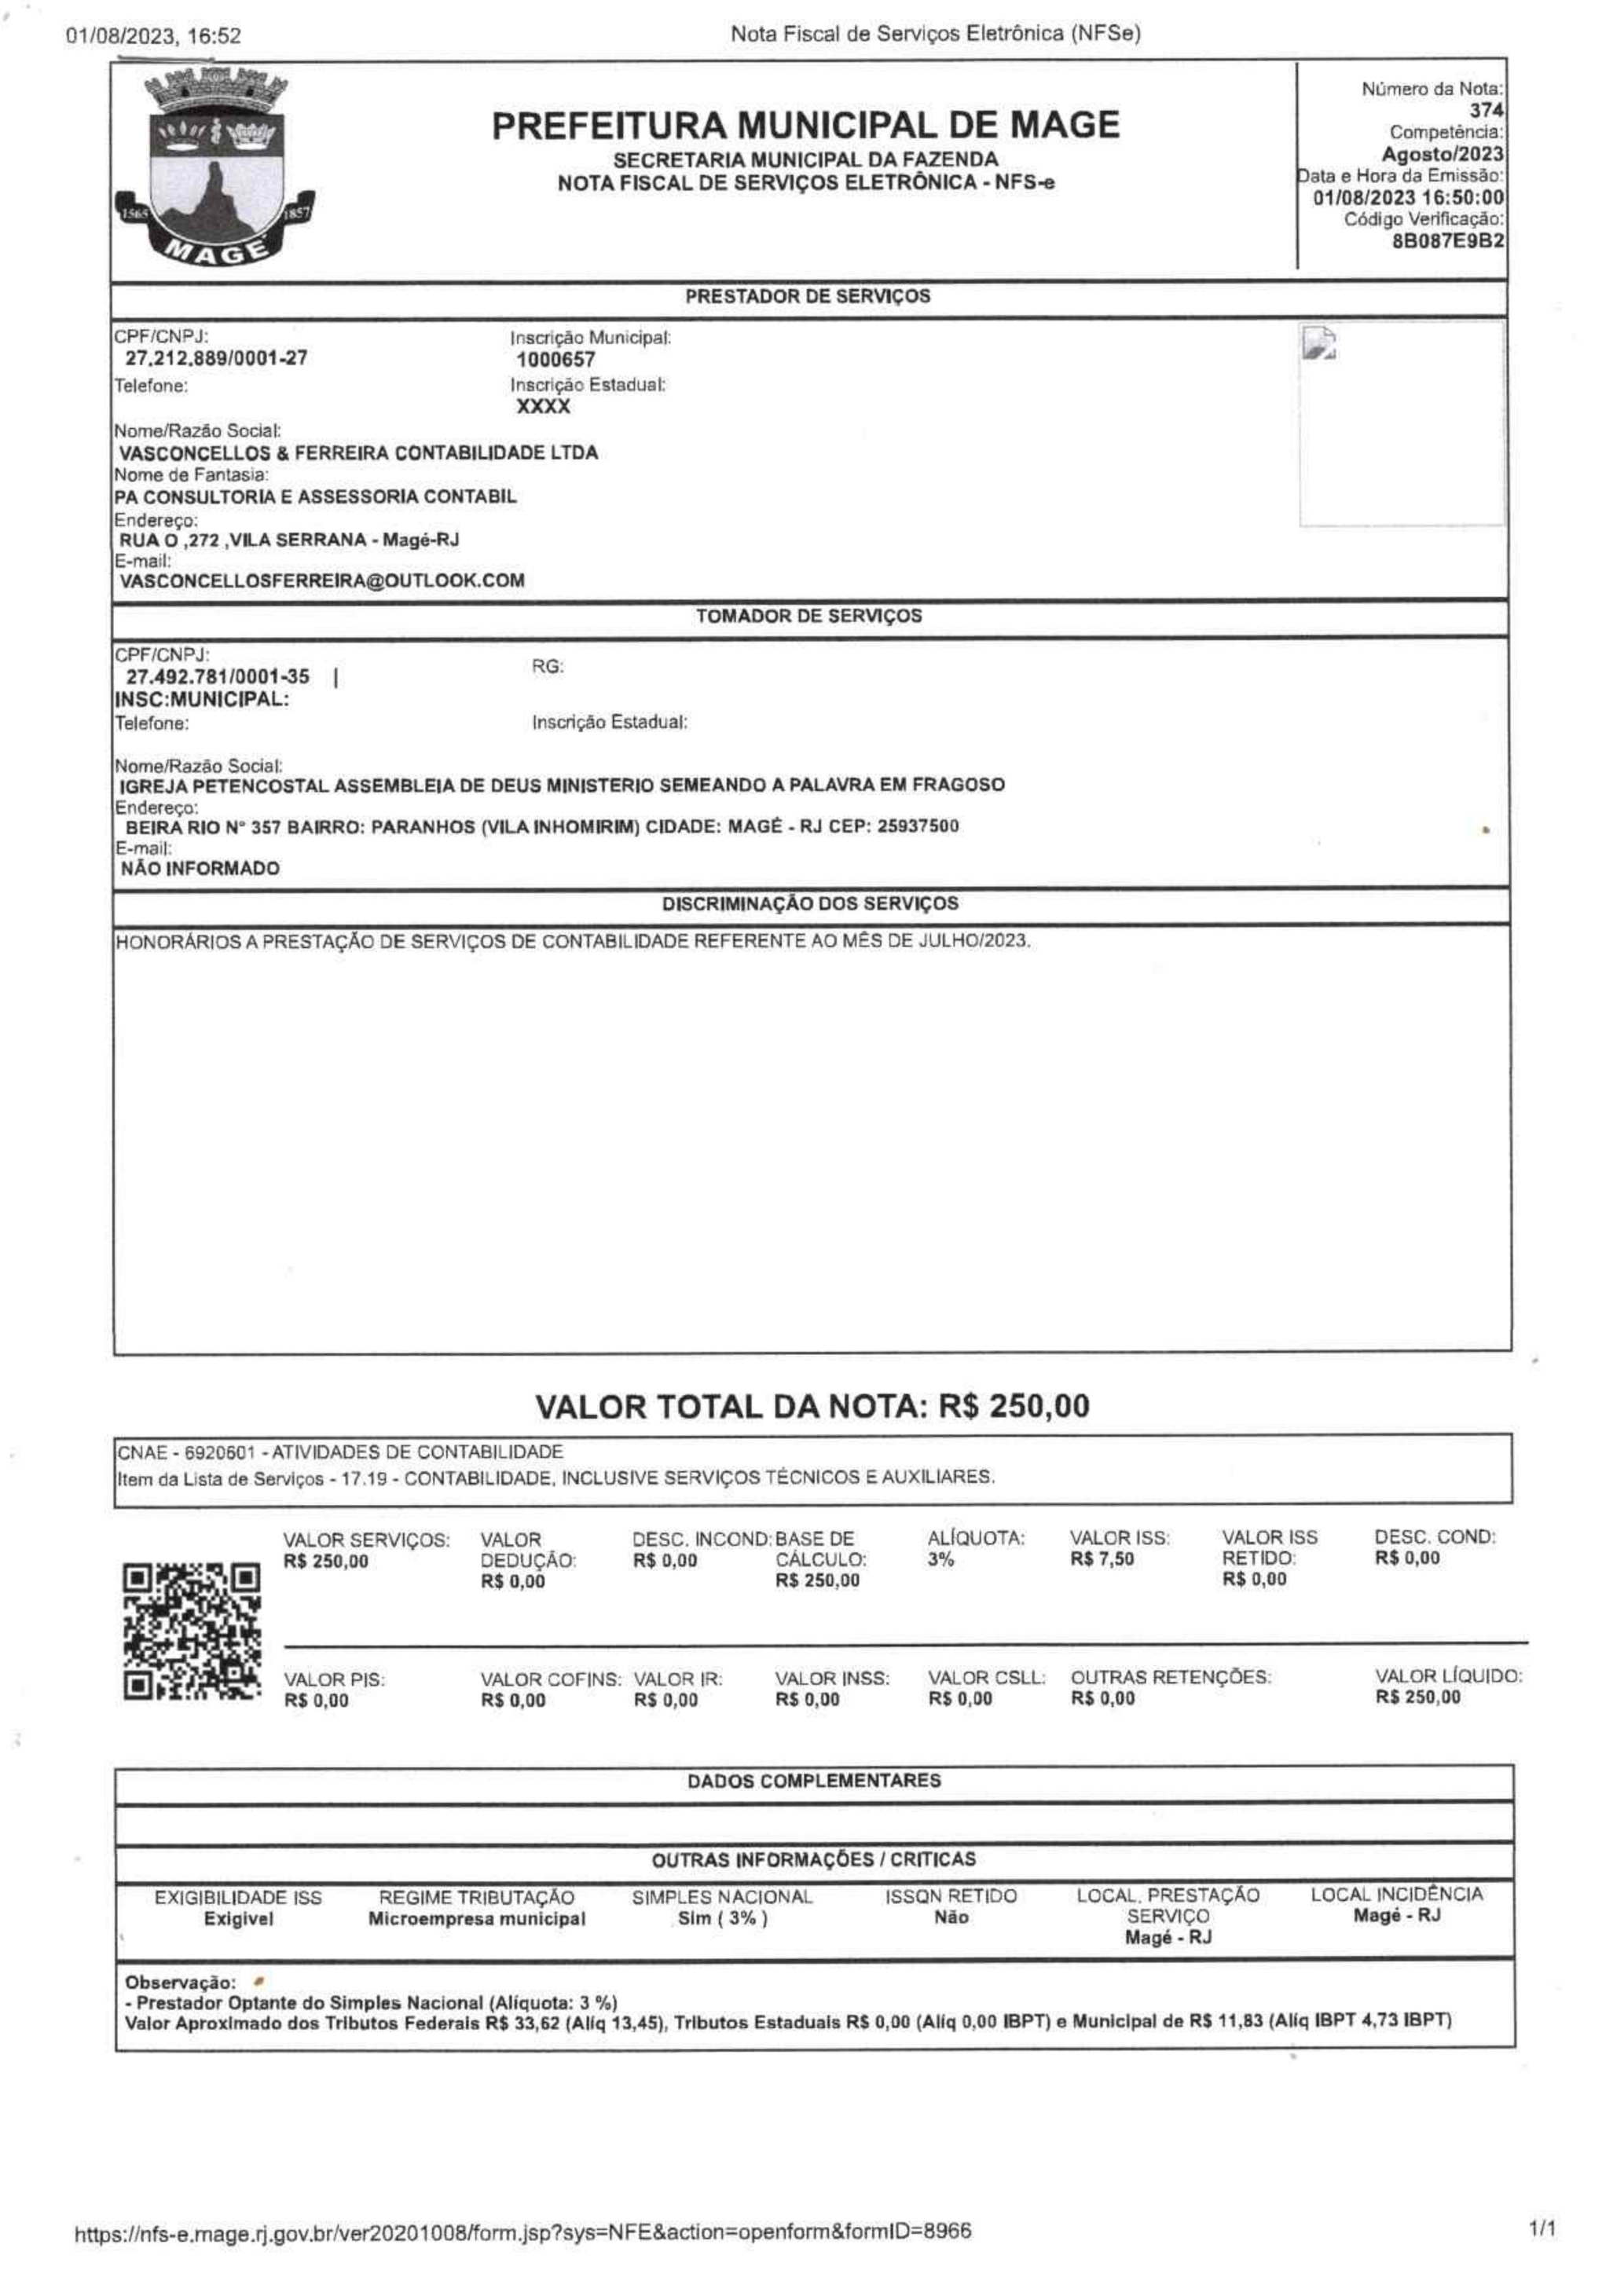

In [20]:
image_2work

In [ ]:
return values, extracted_text_frame 

In [ ]:
result

In [ ]:
texto_extraido

In [ ]:
image_2work

In [ ]:
        # secao: 8 - DADOS COMPLEMENTARES"
        data_dados_complementares = {}
        f_father = "5_frame_dados_complementares"
        section = "8. DADOS COMPLEMENTARES"

        data_dados_complementares = extract_dados_comple_obs(modelo, f_father, section)                                           
                                
                                
        # secao: 9 - OUTRAS INFORMAÇOES / CRITICAS
        data_outras_informacoes = {}
        father_value = "5_frame_inf_criticas"
        section = "9. OUTRAS INFORMAÇOES / CRITICAS"

        result = extract_fields_box(modelo, father_value, section)
        if result:
            data_outras_informacoes.update(result)                        
                            

        # secao: 10. OBSERVACOES
        data_observacao = {}
        f_father = "5_frame_observacao"
        section = "10. OBSERVACOES"

### checagem

In [ ]:
result

In [ ]:
data_servico

In [ ]:
Texto_extraido
text_splited = Texto_extraido.split('\n')

In [ ]:
text_splited

In [ ]:
text_splited = [s.replace(":", "") for s in text_splited]

In [ ]:
text_splited = [s.replace(";", "").strip() for s in text_splited]

In [ ]:
text_splited = [x for x in text_splited if x.strip()]

In [ ]:
text_splited

### novissimas funcoes de extracao

In [ ]:
def find_value_after_keyword_out_frame_up(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
        if text_list[index + 1] not in default_keyword_list:
            return text_list[index + 1]
        else:
            return "Valor não encontrado"  # Ou pode retornar None ou uma string vazia, conforme sua necessidade
    except ValueError:
        if default_keyword_list:
            for default_keyword in default_keyword_list:
                if default_keyword in text_list:
                    # Caso especial para 'Nome/Razão Social:'
                    if keyword == 'Nome/Razão Social:':
                        return text_list[0]
        return "Keyword não encontrada"

In [ ]:
def find_value_after_keyword_out_frame_down(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o índice seguinte está dentro da lista
        if index + 1 < len(text_list):
            # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return "Valor não encontrado"
        else:
            return "Keyword é o último elemento, valor não encontrado"
    except ValueError:
        if default_keyword_list:
            try:
                index = text_list.index(default_keyword_list[-1])
                return text_list[index - 1]
            except ValueError:
                return "Keyword não encontrada"
        else:
            return "Keyword não encontrada"

In [ ]:
def find_value_after_keyword_fuzz(keyword, text_list, default_keyword_list=None, fuzziness_threshold=80):
    closest_match = None
    closest_match_score = 0
    
    for i, text in enumerate(text_list):
        score = fuzz.ratio(keyword, text)
        
        if score > closest_match_score:
            closest_match_score = score
            closest_match = text
        
        if closest_match_score > fuzziness_threshold:
            break

    if closest_match_score > fuzziness_threshold:
        index = text_list.index(closest_match)
        if index + 1 < len(text_list):
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return "Valor não encontrado"
        else:
            return "Keyword é o último elemento, valor não encontrado"
    else:
        return "Keyword não encontrada"

### frame_pesquisa = "1_frame_dados_nf"

In [ ]:
#5. Itero sobre text_splited (lista)
a = 0
for texto_spl in text_splited:
    print(f'texto_spl linha {a}: {texto_spl}')

    a += 1

In [ ]:
keyword_list = ['Número da Nota:', 'Competência:', 'Data e Hora da Emissão:', 'Código Verificação:']

In [ ]:
string_pesquisa = "Número da Nota:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
string_pesquisa = "Competência:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
string_pesquisa = "Código Verificação:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
string_pesquisa = "ata e Hora da Emissão:"

resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

### frame_pesquisa = "2_frame_inscricao_prestador"

In [ ]:
#5. Itero sobre text_splited (lista)
a = 0
for texto_spl in text_splited:
    print(f'texto_spl linha {a}: {texto_spl}')

    a += 1

In [ ]:
keyword_list = ['Inscrição Municipal:', 'Inscrição Estadual:']

In [ ]:
string_pesquisa = "Inscrição Municipal:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
string_pesquisa = "Inscrição Estadual:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

### frame_pesquisa = "2_frame_dados_prestador"

In [ ]:
#5. Itero sobre text_splited (lista)
a = 0
for texto_spl in text_splited:
    print(f'texto_spl linha {a}: {texto_spl}')

    a +=1

In [ ]:
keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']

string_pesquisa = "Nome/Razão Social:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')
    



In [ ]:
keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']

string_pesquisa = "Nome de Fantasia:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']

string_pesquisa = "Endereço:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')


In [ ]:
keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']

string_pesquisa = "E-mail:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

### frame_pesquisa = "3_frame_inscricao_tomador"

In [ ]:
#5. Itero sobre text_splited (lista)
a = 0
for texto_spl in text_splited:
    print(f'texto_spl linha {a}: {texto_spl}')

    a += 1

In [ ]:
keyword_list = ['RG:', 'Inscrição Estadual:']

In [ ]:
string_pesquisa = "RG:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
string_pesquisa = "Inscrição Estadual:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

### frame_pesquisa ="3_frame_dados_tomador"

In [ ]:
#5. Itero sobre text_splited (lista)
a = 0
for texto_spl in text_splited:
    print(f'texto_spl linha {a}: {texto_spl}')

    a +=1

In [ ]:
keyword_list = ['Nome/Razão Social:', 'Endereço:', 'E-mail']

string_pesquisa = "Nome/Razão Social:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')
    

In [ ]:
keyword_list = ['Nome/Razão Social:', 'Endereço:', 'E-mail']

string_pesquisa = "Endereço:"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

In [ ]:
keyword_list = ['Nome/Razão Social:', 'Endereço:', 'E-mail']

string_pesquisa = "E-mail"


resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)
if resultado_extraido_fuzz == "Keyword não encontrada":
    resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
    if resultado_extraido_frame_up == "Keyword não encontrada":
        resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
        resultado_extraido = resultado_extraido_frame_down
    else:
        resultado_extraido = resultado_extraido_frame_up
else:
    resultado_extraido = resultado_extraido_fuzz           
    
print(f'"{resultado_extraido}"')

### frame_pesquisa = "4_frame_descricao_totais"

In [ ]:
nf_data_servico = {}
label = "DISCRIMINAÇÃO DOS SERVIÇOS"
if texto_extraido.startswith(label):
    text = texto_extraido[len(label):].strip()
nf_data_servico['discriminacao_servicos'] = text 
print(nf_data_servico)

In [ ]:
print(nf_data_servico)

### frame_pesquisa = "4_frame_valor_total"

In [ ]:
Texto_extraido

In [ ]:
match = re.search(r'R\$\s[\d,.]+', Texto_extraido)

if match:
    extracted_value = match.group(0)
else:
    extracted_value = "Valor não encontrado"

valor_total = format_number(extracted_value)

print(valor_total)

### frame_pesquisa = "4_frame_cnae_itens_servico"

In [ ]:

mage_cnae_x_item_servico_df = pd.read_excel('pipeline_extracao_documentos/6_geral_administacao/datasets/MAGE_CNAE_X_ITEM_SERVICO_V1.xlsx')

# Creating a dictionary for CNAE codes and descriptions
cnae_dict = dict(zip(mage_cnae_x_item_servico_df['cnae'], mage_cnae_x_item_servico_df['descricao_cnae']))
item_servico_dict = dict(zip(mage_cnae_x_item_servico_df['item_servico'], mage_cnae_x_item_servico_df['descricao_item_servico']))



# Função para extrair número da string
def extract_number(text):
    match = re.search(r'\b\d+(\.\d+)?\b', text)
    if match:
        return match.group(0)
    else:
        return None

In [ ]:
Texto_extraido
text_splited = Texto_extraido.split('\n')

In [ ]:
# Processando CNAE
cnae_line = [line for line in text_splited if 'CNAE' in line][0]
cnae_number = int(extract_number(cnae_line))
cnae_value = cnae_dict.get(cnae_number, "Valor não encontrado")
cnae_value = cnae_value.upper()
cnae_value = str(cnae_number) + " - " + cnae_value
print(cnae_value)

In [ ]:
# Processando Item de Serviço
item_servico_line = [line for line in text_splited if 'Item da Lista de Serviços' in line][0]
item_servico_number = float(extract_number(item_servico_line))
item_servico_value = item_servico_dict.get(item_servico_number, "Valor não encontrado")
item_servico_value = item_servico_value.upper()
item_servico_value = str(item_servico_number) + " - " + item_servico_value
print(item_servico_value)

## Desenha Box

In [ ]:
name_image_2work = "pipeline_extracao_documentos/6_geral_administacao/images/processadas/Doria Marinho 0297 Raquel.pdf.jpg"

In [ ]:
name_image_2work = "pipeline_extracao_documentos/6_geral_administacao/images/processadas/Doria Marinho 0299 Luciana.pdf.jpg"

In [22]:
# Define a mapping for color names to RGB values
color_mapping = {
    "red": (255, 0, 0),
    "purple": (128, 0, 128),
    "orange": (255, 165, 0),
    "green": (0, 128, 50),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0)
}

# Reload the image to start fresh
image = Image.open(name_image_2work)
draw = ImageDraw.Draw(image)

# Define a font size for the labels using the default PIL font
font_size = 100
#font = ImageFont.load_default()

font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf", 30, encoding="unic")

# Update the draw_box function to use the larger font size with the default font
def draw_box(row):
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    color = color_mapping.get(row['color'], (0, 0, 0)) # Default to black if color not found
    draw.rectangle([x0, y0, x1, y1], outline=color, width=3)
    label = str(row['label']) if pd.notnull(row['label']) else None # Check for missing label
    if label:
        draw.text((x0 + 5, y0 + 5), label, fill=color, font=font)

# Draw the boundaries
#draw_box(boundaries_info)


def draw_box_model(modelo,
                   boundaries_info=None,
                   sections_info=None,
                   frames_info=None,
                   field_boxes_info=None,
                   draw_boundaries=True,
                   draw_sections=True,
                   draw_frames=True,
                   draw_field_boxes=True):
    
    # Draw boundaries if requested
    if draw_boundaries and boundaries_info is not None:
        filtered_boundaries_info = boundaries_info[boundaries_info['model'] == modelo]
        for index, row in filtered_boundaries_info.iterrows():
            draw_box(row)

    # Draw sections if requested
    if draw_sections and sections_info is not None:
        filtered_sections_info = sections_info[sections_info['model'] == modelo]
        for index, row in filtered_sections_info.iterrows():
            draw_box(row)
            
    # Draw frames if requested
    if draw_frames and frames_info is not None:
        filtered_frames_info = frames_info[frames_info['model'] == modelo]
        for index, row in filtered_frames_info.iterrows():
            draw_box(row)
            
    # Draw field boxes if requested
    if draw_field_boxes and field_boxes_info is not None:
        filtered_field_boxes_info = field_boxes_info[field_boxes_info['model'] == modelo]
        for index, row in filtered_field_boxes_info.iterrows():
            draw_box(row)
    
    # Show the image with selected drawings
    image.show()

In [ ]:
modelo = "mage_1"

In [23]:
# To draw everything
draw_box_model(modelo, boundaries_info, sections_info, frames_info, field_boxes_info)


[18044:18070:0827/200934.803613:ERROR:bus.cc(399)] Failed to connect to the bus: Failed to connect to socket /run/dbus/system_bus_socket: No such file or directory
[18044:18076:0827/200934.843719:ERROR:bus.cc(399)] Failed to connect to the bus: Failed to connect to socket /run/dbus/system_bus_socket: No such file or directory
[18044:18076:0827/200934.843769:ERROR:bus.cc(399)] Failed to connect to the bus: Failed to connect to socket /run/dbus/system_bus_socket: No such file or directory
[18044:18070:0827/200934.849091:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")
[18044:18070:0827/200934.849146:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")
[18044:18070:0827/200934.849157:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address t

In [ ]:
# To draw only boundaries and sections:
draw_box_model(modelo, boundaries_info, sections_info, draw_frames=False, draw_field_boxes=False)


In [ ]:
# To draw only field boxes:
draw_box_model(modelo, field_boxes_info=field_boxes_info, draw_boundaries=False, draw_sections=False, draw_frames=False)


In [ ]:
        # secao: 5 - VALOR TOTAL
        data_valor_total = {}
        #data_valor_total = processa_total()
        father_value = "4_frame_valor_total"
        section = "5. VALOR TOTAL"
        
        result = extract_fields_box(modelo, father_value, section)
        if result:
            data_valor_total.update(result)
        
        # secao: 6 - CNAE e Item da Lista de Serviços
        data_CNAE = {}
        data_CNAE = processa_cnae_itens()

        # secao: 7 - VALORES E IMPOSTOS & 9 - OUTRAS INFORMAÇOES / CRITICAS
        data_valores = {}
        father_value = "5_frame_valores_impostos"
        section = "7. VALORES E IMPOSTOS"

        result = extract_fields_box(modelo, father_value, section)
        if result:
            data_valores.update(result)
            
        # secao: 8 - DADOS COMPLEMENTARES"
        data_dados_complementares = {}
        f_father = "5_frame_dados_complementares"
        section = "8. DADOS COMPLEMENTARES"

        data_dados_complementares = extract_dados_comple_obs(modelo, f_father, section)                                           
                                
                                
        # secao: 9 - OUTRAS INFORMAÇOES / CRITICAS
        data_outras_informacoes = {}
        father_value = "5_frame_inf_criticas"
        section = "9. OUTRAS INFORMAÇOES / CRITICAS"

        result = extract_fields_box(modelo, father_value, section)
        if result:
            data_outras_informacoes.update(result)                        
                            

        # secao: 10. OBSERVACOES
        data_observacao = {}
        f_father = "5_frame_observacao"
        section = "10. OBSERVACOES"

        data_observacao = extract_dados_comple_obs(modelo, f_father, section)

## Outras funcoes deprecateds

In [ ]:
def find_value_after_keyword_out_frame(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o índice seguinte está dentro da lista
        if index + 1 < len(text_list):
            # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return "Valor não encontrado"
        else:
            return "Keyword é o último elemento, valor não encontrado"
    except ValueError:
        if default_keyword_list:
            try:
                index = text_list.index(default_keyword_list[-1])
                return text_list[index - 1]
            except ValueError:
                return "Keyword não encontrada"
        else:
            return "Keyword não encontrada"


In [ ]:
def find_value_after_keyword(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o índice seguinte está dentro da lista
        if index + 1 < len(text_list):
            # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return "Valor não encontrado"
        else:
            return "Keyword é o último elemento, valor não encontrado"
    except ValueError:
        if default_keyword_list:
            try:
                index = text_list.index(default_keyword_list[-1])
                return text_list[index - 1]
            except ValueError:
                return "Keyword não encontrada"
        else:
            return "Keyword não encontrada"